# Softmax exercise

The intent of this ipynb is only to explain softmax loss gradient calculation. I am taking cs231 assignment code to  [cs231n assignment1](http://vision.stanford.edu/teaching/cs231n/assignments.html). 

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


# Softmax gradient calculation

## Sofmax score

After multiplying input matrix X with weights matrix W we get class scores. Then we apply softmax function over it. Sofmax score function $p(z)$ takes a vector of arbitrary real-valued scores (e.g. predicted scores $z[]$) and squashes it to a vector of values between zero and one. 

$$ p_j(z) = \frac { e^{z_j} } { \sum_k {e^{z_k}} }  $$ 

Example,

In [3]:
from cs231n.classifiers.softmax import softmax
z = np.array([10.0,5.0,5.0])
p = softmax(z)
print p

[[ 0.98670329  0.00664835  0.00664835]]


## Cross Entropy Loss

The cross-entropy between a "true" distribution $p$ and an estimated distribution $q$ is defined as:

$$ H(p,q) = -\sum_x p(x) log( q(x) ) $$ 

The Softmax classifier is hence minimizing the cross-entropy between the estimated class probabilities $p(z)$ and the "true" distribution, which in this interpretation is the distribution where all probability mass is on the correct class (i.e. p=[0,…1,…,0]p=[0,…1,…,0] contains a single 1 at the $yi$-th position.). For simplicity, let's consider $Y$ as one-hot encoded labels for $y$

$$L_i = -\sum_j Y_j log( \frac { e^{f_{j}} } { \sum_k {e^{f_k}} } )$$

$Y_j$ is zero except at position $y_i$ which represents true class label for $i$-th training input. So, our loss equation simplifies to: 

$$L_i = -log( \frac { e^{f_{y_i}} } { \sum_k {e^{f_k}} } )$$

Simplifying further...

$$L_i = -f_{y_i} + log(\sum_k {e^{f_k}})$$

$$L_i = -w_{y_i}x_i + log(\sum_k {e^{w_k x_i}})$$

## Gradient of the loss function

$$\frac{\delta L_i}{\delta w_j} = -\frac{\delta w_{y_i}} {\delta w_j} x_i + \frac {1} {\sum_k {e^{w_k x_i}}} \frac{\delta \sum_k e^{w_k x_i}}{\delta w_j} $$

Because $\frac{\delta e^{w_k}}{\delta w_j} = 0 $; except when $k == j$. Applying chain rule leads to:

$$\frac{\delta L_i}{\delta w_j} = -\frac{\delta w_{y_i}} {\delta w_j} x_i + \frac {e^{w_j x_i}} {\sum_k {e^{w_k x_i}}} x_i $$

The term $\frac {e^{w_j x_i}} {\sum_k {e^{w_k x_i}}}$ is the softmax score for the class j which we already computed i.e. $p_j(z)$. In other words:

$$\frac{\delta L_i}{\delta w_j} = -\frac{\delta w_{y_i}} {\delta w_j} x_i + f_j x_i $$



$$
\begin{equation}
\begin{aligned}
j == y_i \implies \frac{\delta w_{y_i}} {\delta w_j} = 1 \\
j \not= y_i \implies \frac{\delta w_{y_i}} {\delta w_j} = 0  \\
\end{aligned}
\end{equation}
$$ 

Our final gradient update becomes:
~~~python 
dW[:,j] += (p[j] - (j==y[i]))*X[i,:] 
~~~


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.305417
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *There are 10 classes, so with random weights we expect to get correct output with the probability of 0.1. We accumulate negative log loss of the incorrect class probability score, i.e., -log(0.1)*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.529982 analytic: -2.529982, relative error: 4.152038e-09
numerical: 0.779322 analytic: 0.779322, relative error: 3.315105e-08
numerical: -1.445510 analytic: -1.445510, relative error: 2.059065e-08
numerical: 0.281342 analytic: 0.281341, relative error: 3.343781e-08
numerical: -6.839533 analytic: -6.839533, relative error: 6.066108e-09
numerical: 0.792567 analytic: 0.792567, relative error: 3.889899e-08
numerical: 0.282175 analytic: 0.282175, relative error: 2.010428e-08
numerical: 2.161198 analytic: 2.161198, relative error: 1.084646e-08
numerical: 1.663014 analytic: 1.663014, relative error: 1.886759e-09
numerical: -0.376587 analytic: -0.376587, relative error: 1.909571e-07
numerical: -5.406960 analytic: -5.406960, relative error: 1.030832e-08
numerical: 0.337874 analytic: 0.337874, relative error: 1.599521e-07
numerical: 0.004892 analytic: 0.004892, relative error: 1.452891e-06
numerical: -0.680136 analytic: -0.680136, relative error: 2.738732e-08
numerical: 1.491779 an

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.305417e+00 computed in 0.094722s
vectorized loss: 2.305417e+00 computed in 0.003480s
Loss difference: 0.000000
Gradient difference: 0.000000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]
best_learning_rate = None
best_reg  = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
     for reg in regularization_strengths:
 
        print "learning rate = ", learning_rate, "reg = ", reg
        softmax_ = Softmax()
        loss = softmax_.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=300, verbose=True)
        y_train_pred = softmax_.predict(X_train)
        train_accuracy = (np.mean(y_train == y_train_pred))
        y_val_pred = softmax_.predict(X_val)
        valid_accuracy = (np.mean(y_val == y_val_pred))
        results[(learning_rate, reg)] = (train_accuracy, valid_accuracy)
        if best_val == -1 or valid_accuracy > best_val:
            best_val = valid_accuracy
            best_softmax = softmax_
            best_learning_rate = learning_rate
            best_reg = reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

learning rate =  1e-07 reg =  50000.0
iteration 0 / 300: loss 776.869953
learning rate =  1e-07 reg =  100000000.0
iteration 0 / 300: loss 1504122.427019
learning rate =  5e-07 reg =  50000.0
iteration 0 / 300: loss 766.450710
learning rate =  5e-07 reg =  100000000.0
iteration 0 / 300: loss 1528262.360743
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.246510 val accuracy: 0.230000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.121633 val accuracy: 0.121000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.335633 val accuracy: 0.347000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.347000


In [17]:
# let's train more with the best learning rate and regularization setting
softmax_ = Softmax()
loss = softmax_.train(X_train, y_train, learning_rate=best_learning_rate, reg=best_reg,
                      num_iters=10000, verbose=True)
best_softmax = softmax_

iteration 0 / 10000: loss 778.503164
iteration 1000 / 10000: loss 2.103660
iteration 2000 / 10000: loss 2.069648
iteration 3000 / 10000: loss 2.069189
iteration 4000 / 10000: loss 2.084286
iteration 5000 / 10000: loss 2.068204
iteration 6000 / 10000: loss 2.098305
iteration 7000 / 10000: loss 2.057195
iteration 8000 / 10000: loss 2.037399
iteration 9000 / 10000: loss 2.064922


In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.337000


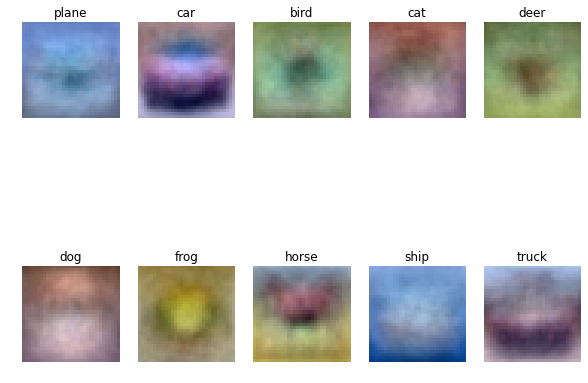

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])